In [1]:
import scipy.io as sio
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("dark")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation, find_permutation

In [2]:
def format_data(input):
    datas = []
    for i in range(input.shape[0]):
        input_cur = np.squeeze(input[i,:,:])

        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(input_cur, dtype=int))
    return datas

mat = sio.loadmat('rawdata.mat', squeeze_me=True, variable_names={'spdata','inpdata'})
data_sp = format_data(mat['spdata'])
data_inp = format_data(mat['inpdata'])

binsize = 0.01
n_trials = mat['spdata'].shape[0]
n_timebins = mat['spdata'].shape[1]
n_neurons = mat['spdata'].shape[2]

inp_dim = mat['inpdata'].shape[2]
state_dim = 10
disc_dim = 3

In [3]:
fit_lds = ssm.LDS(n_neurons, state_dim, 
                   M = inp_dim,
                   transitions="sticky",
                   emissions="poisson_orthog", 
                   emission_kwargs=dict(link="softplus", bin_size=binsize))

# fit_lds = ssm.SLDS(n_neurons, disc_dim, state_dim, 
#                    M = inp_dim,
#                    transitions="sticky",
#                    emissions="poisson_orthog", 
#                    emission_kwargs=dict(link="softplus", bin_size=binsize))

fit_lds.initialize(data_sp)

elbos, q = fit_lds.fit(data_sp, inputs = data_inp, 
                       method="laplace_em",
                       variational_posterior="structured_meanfield",
                       initialize=False,
                       num_iters=10)

Initializing with an ARHMM using 25 steps of EM.


KeyboardInterrupt: 

In [ ]:
# Plot the ELBOs
plt.plot(elbos[0:10], label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

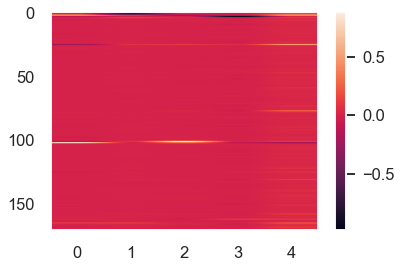

In [43]:
plt.figure()
plt.imshow(fit_lds.emissions.Cs[0,:,:],aspect='auto')
plt.colorbar()

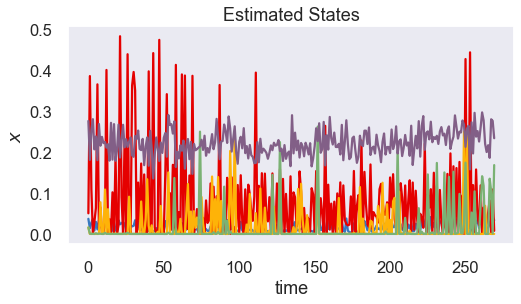

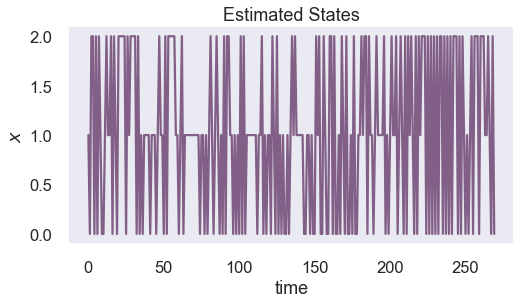

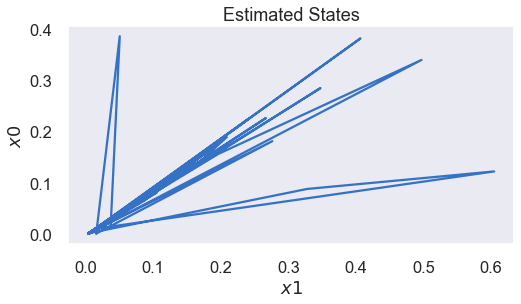

In [48]:
tr = 10

# Get the posterior mean of the continuous states
q_x = q.mean_continuous_states[tr]

# Smooth the data under the variational posterior
yhat = fit_lds.smooth(q_x, data_sp[tr], input=data_inp[tr])
zhat = fit_lds.most_likely_states(q_x, data_sp[tr], input=data_inp[tr])

plt.figure(figsize=(8,4))
for d in range(state_dim):
    plt.plot(yhat[:,d], '-', color=colors[d], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
# plt.legend(loc='upper right')
plt.title("Estimated States")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(zhat, '-', color=colors[d], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
# plt.legend(loc='upper right')
plt.title("Estimated States")
plt.show()


plt.figure(figsize=(8,4))
plt.plot(yhat[0,:], yhat[1,:])
plt.ylabel("$x0$")
plt.xlabel("$x1$")
# plt.legend(loc='upper right')
plt.title("Estimated States")
plt.show()


In [49]:
z_sim, x_sim, y_sim = fit_lds.sample(n_timebins, data_inp[tr])

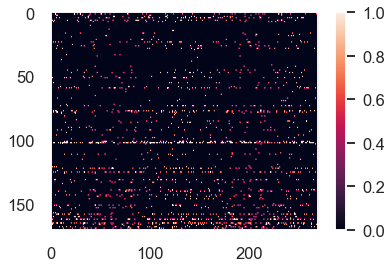

In [50]:
plt.figure()
plt.imshow(y_sim.T,aspect='auto',vmax = 1)
plt.colorbar()

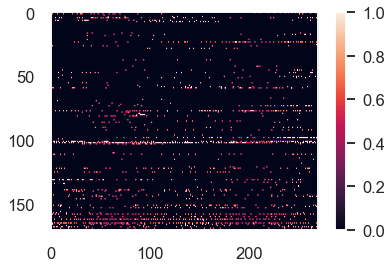

In [51]:
plt.figure()
plt.imshow(data_sp[tr].T, aspect='auto',vmax =1)
plt.colorbar()

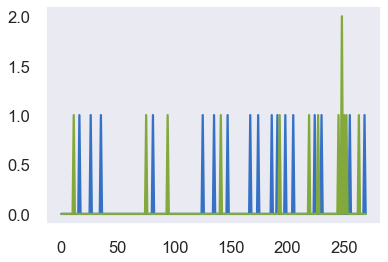

In [60]:
cnum = 45
plt.figure()
plt.plot(y_sim[:,cnum])
plt.plot(data_sp[tr][:,cnum])

# slowdrift tries

In [2]:
import scipy.io as sio

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation
from ssm.plots import plot_dynamics_2d
import pandas as pd

# Specify whether or not to save figures
save_figures = False

In [3]:
# Set the parameters of the LDS
trials = 80000   # number of trials
state_dim = 1     # number of latent dimensions
obs_dim = 1      # number of observed dimensions
input_dim = 5    # number of input dimensions

# generating data without history

In [3]:
# Make an LDS with somewhat interesting dynamics parameters
true_lds = ssm.LDS(obs_dim, state_dim, M = input_dim, dynamics = "gaussian", emissions="bernoulli")

inpt =  np.round(npr.rand(trials, input_dim), decimals = 2)

true_lds.dynamics.A = np.ones((state_dim,state_dim), dtype= float)   # dynamics
true_lds.dynamics.b = np.zeros(state_dim, dtype= float)              # bias
true_lds.dynamics.mu_init = np.zeros((state_dim,state_dim), dtype= float)    # initial mu
true_lds.dynamics.Sigmas_init = np.array([[[.000001]]])     # initial sigma
true_lds.dynamics.Sigmas = np.array([[[.00001]]])          # sigma
true_lds.dynamics.Vs = np.array([[[0.]]])               # input dynamics

true_lds.emissions.Cs = np.array([[[1.]]])
true_lds.emissions.ds = -5*np.ones(state_dim, dtype= float)
true_lds.emissions.Fs = np.array([[[10.]]])
true_lds.emissions.F = np.array([[[10.]]])

states, emissions = true_lds.sample(trials, input = inpt)

ValueError: shapes (1,1) and (5,) not aligned: 1 (dim 1) != 5 (dim 0)

# generating data with history

In [4]:
sigma = .01
bias = -5
g = 10.
C = 1.
g_rc = 2   # sameness produces wsstay loseswitc
g_re = 2
g_lc = -2
g_le = -2

data = {}
data_nod = {}

inpt =  np.round(npr.rand(trials), decimals = 2)
states = np.cumsum((sigma * npr.randn(trials,1)))

In [5]:
C = 1.

hist_c = []
hist_o = []
emissions = []

inputs = np.ones((trials, input_dim))
inp_add = np.ones((trials, 2))

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

choice_h = 2*(1-0.5)
outcome = 2*(1-0.5)

choice = True
rc = 1
re = 0
lc = 0
le = 0

for i in range(trials):
        
    inputs[i,0] = inpt[i]
    inputs[i,1] = rc
    inputs[i,2] = re
    inputs[i,3] = lc
    inputs[i,4] = le
    
    inp_add[i,0] = choice_h
    inp_add[i,1] = outcome 
    
#     pR = sigmoid(g*inpt[i] + g_c*choice_h + g_o*outcome + bias + C*states[i])
    pR = sigmoid(g*inpt[i] + g_rc*rc + g_re*re + g_lc*lc + g_le*le + bias + C*states[i])
    choice = npr.rand()<pR
    
    choice_h = 2*(choice-0.5)
    outcome = 2*((((inpt[i] > 0.5) & choice) | ((inpt[i] < 0.5) & ~choice)) - 0.5)
    
    rc = 1*((choice) & (inpt[i] > 0.5))
    re = 1*((choice) & (inpt[i] < 0.5))
    lc = 1*((~choice) & (inpt[i] < 0.5))
    le = 1*((~choice) & (inpt[i] > 0.5))
    
    
    emissions.append([choice*1])
    hist_c.append(choice_h)
    hist_o.append(outcome)
    
   
emissions = np.array(emissions)


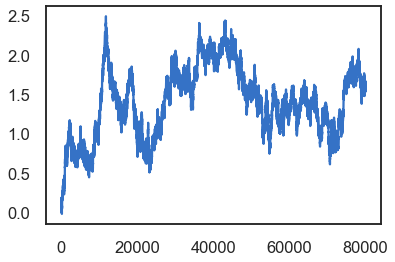

In [6]:
plt.plot(states)
data_nod["pokedR"] = np.concatenate(np.array(emissions))
# data["stimulus"] = np.concatenate(inpt)

data_nod["stimulus"] = inputs[:,0]
data_nod["prev_choice"] = inp_add[:,0]
data_nod["prev_outcome"] = inp_add[:,1]
data_nod["rc"] = inputs[:,1]
data_nod["re"] = inputs[:,2]
data_nod["lc"] = inputs[:,3]
data_nod["le"] = inputs[:,4]

df_nod = pd.DataFrame(data_nod)

Text(0, 0.5, 'Slow drifts (random walk)')

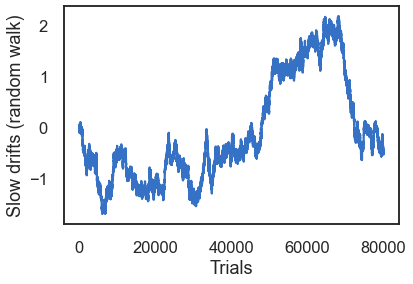

In [17]:
data["pokedR"] = np.concatenate(np.array(emissions))
# data["stimulus"] = np.concatenate(inpt)

data["stimulus"] = inputs[:,0]
data["prev_choice"] = inp_add[:,0]
data["prev_outcome"] = inp_add[:,1]
data["rc"] = inputs[:,1]
data["re"] = inputs[:,2]
data["lc"] = inputs[:,3]
data["le"] = inputs[:,4]

df = pd.DataFrame(data)

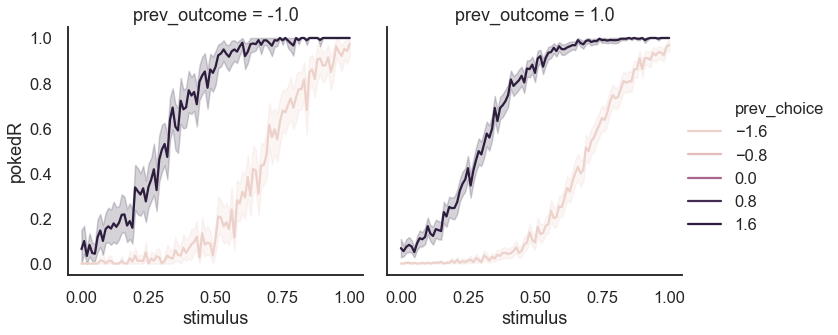

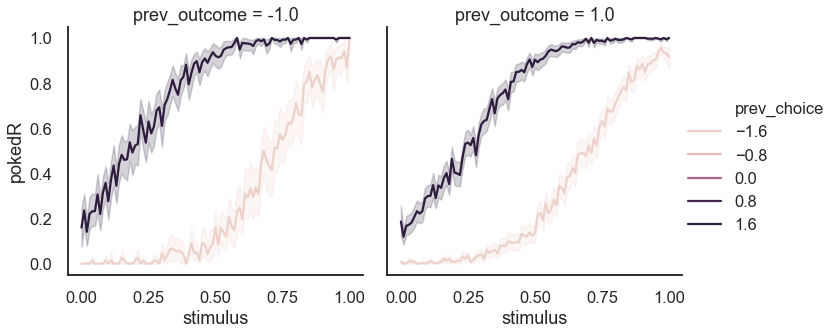

In [99]:
sns.relplot(x="stimulus", y="pokedR",  hue = "prev_choice", col="prev_outcome", kind="line", data=df_nod);
sns.relplot(x="stimulus", y="pokedR",  hue = "prev_choice", col="prev_outcome", kind="line", data=df);

In [7]:
emissions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [6]:
print("Fitting LDS with Laplace-EM using structured variational posterior")

lds = ssm.LDS(obs_dim, state_dim, M = input_dim, emissions="bernoulli")

lds.dynamics.A = np.ones((state_dim,state_dim), dtype= float)   # dynamics
lds.dynamics.b = np.zeros(state_dim, dtype= float)              # bias
lds.dynamics.mu_init = np.zeros((state_dim,state_dim), dtype= float)    # initial mu
lds.dynamics.Sigmas_init = np.array([[[.000001]]])     # initial sigma
lds.dynamics.Vs = np.array([[[0., 0., 0., 0., 0.]]])               # input dynamics

elbos, q = lds.fit(emissions, inputs = inputs, method="laplace_em",
                    variational_posterior="structured_meanfield", 
                    continuous_optimizer='newton',
                    initialize=True, 
                    num_init_restarts=1,
                    num_iters=200, 
                    alpha=0.25)

# Plot the ELBOs
plt.plot(elbos[2:], label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

Fitting LDS with Laplace-EM using structured variational posterior


Initializing with an ARHMM using 25 steps of EM.


KeyboardInterrupt: 

In [20]:
# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states[0]

# Smooth the data under the variational posterior
smoothed_obs = lds.smooth(state_means, data, input = inputs)

[[[-0.08621202]]]


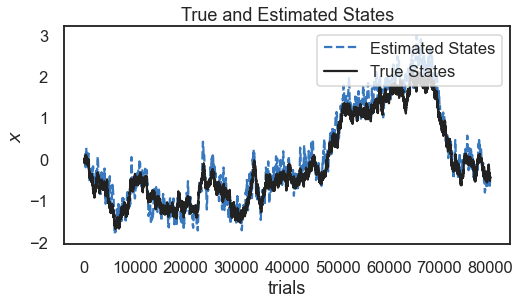

In [26]:
plt.figure(figsize=(8,4))
print(lds.emissions.Cs) 
plt_emissions = (np.squeeze(lds.emissions.Cs) * state_means[:]) #+ (lds.emissions.ds+5)
plt.plot(plt_emissions , '--', color=colors[0], label="Estimated States")
plt.plot(states[:] , '-k', label="True States")

plt.ylabel("$x$")
plt.xlabel("trials")
plt.legend(loc='upper right')
plt.title("True and Estimated States")
plt.show()



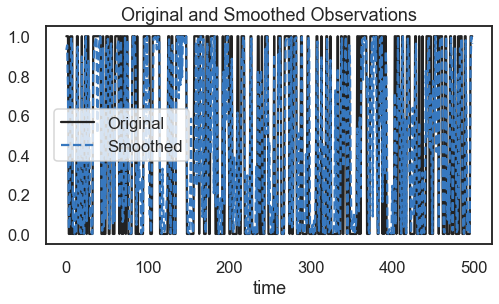

In [45]:
# Plot the smoothed emissions
plt.figure(figsize=(8,4))
for n in range(obs_dim):
    plt.plot(emissions[1:500, n] + 4 * n, '-k', label="Original" if n == 0 else None)
    plt.plot(smoothed_obs[1:500, n] + 4 * n, '--', color=colors[0], label="Smoothed" if n == 0 else None)
plt.legend()
plt.xlabel("time")
plt.title("Original and Smoothed Observations")
plt.show()

In [24]:
print("sigma =", lds.dynamics.Sigmas * np.sqrt(np.abs(lds.emissions.Cs)), "bias = ", lds.emissions.ds, 
      "input weight = ", lds.emissions.Fs)  
print("sigma =", sigma, "bias = ", bias, "input weight = ", [g, g_rc, g_re, g_lc, g_le])    



sigma = [[[0.09314119]]] bias =  [[-3.42807553]] input weight =  [[[11.21356781 -0.11415927 -0.29123382 -4.55705151 -4.5206871 ]]]


In [23]:
print("sigma =", true_lds.dynamics.Sigmas * np.sqrt(true_lds.emissions.Cs), "bias = ", true_lds.emissions.ds, 
      "input weight = ", true_lds.emissions.Fs) 
print("sigma =", sigma, "bias = ", bias, "input weight = ", [g, g_rc, g_re, g_lc, g_le])    



NameError: name 'true_lds' is not defined

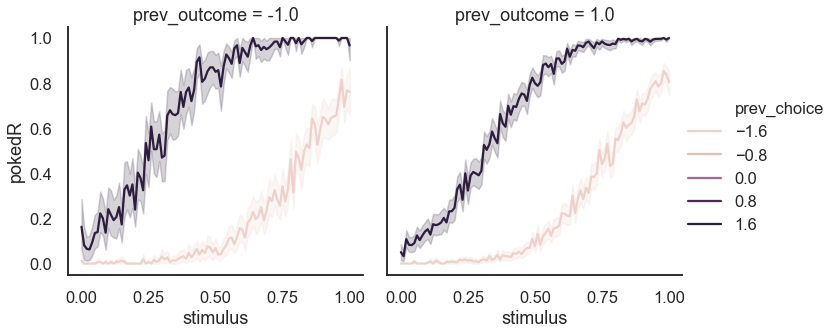

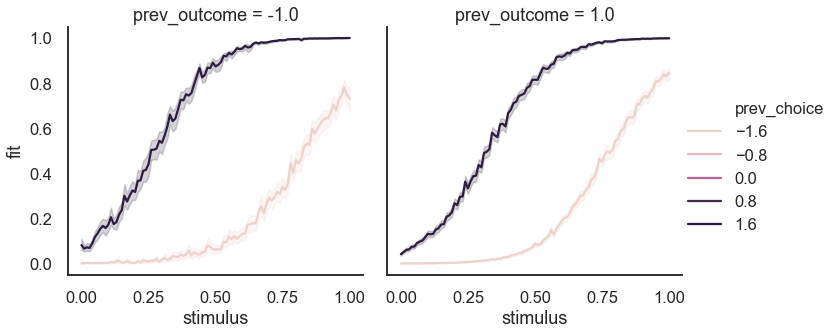

In [49]:
data["fit"] = np.concatenate(smoothed_obs)
df = pd.DataFrame(data)
sns.relplot(x="stimulus", y="pokedR",  hue = "prev_choice", col="prev_outcome", kind="line", data=df);
sns.relplot(x="stimulus", y="fit",  hue = "prev_choice", col="prev_outcome", kind="line", data=df);


lds.emissions.Cs = np.array([[[0.]]])
smoothed_obs_nod = lds.smooth(state_means, data, input = inputs)


data["fit_nod"] = np.concatenate(smoothed_obs_nod)
df = pd.DataFrame(data)
sns.relplot(x="stimulus", y="pokedR",  hue = "prev_choice", col="prev_outcome", kind="line", data=df_nod);
sns.relplot(x="stimulus", y="fit_nod",  hue = "prev_choice", col="prev_outcome", kind="line", data=df);


# fit data next

In [39]:
import os
os.chdir('/Users/dikshagupta/ondrive/analysisDG/PBupsRT/Bingfit_trialhistory/pkg_bing_data/bing_data_forslowdrift/')
print(os.getcwd())

In [66]:
data = sio.loadmat('sd_B107_rawdata.mat', squeeze_me=True, variable_names={'inp', 'emi','inp_add'})
inputs = data["inp"]
emi = data["emi"]
inp_add = data["inp_add"]

# Set the parameters of the LDS
trials = np.size(emi)   # number of trials
state_dim = 1     # number of latent dimensions
obs_dim = 1      # number of observed dimensions
input_dim = 3    # number of input dimensions
emissions = np.array([[bool(emi[i])] for i in range(trials)])


Fitting LDS with Laplace-EM using structured variational posterior


Initializing with an ARHMM using 25 steps of EM.


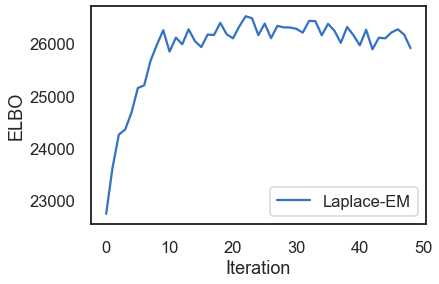

In [71]:
print("Fitting LDS with Laplace-EM using structured variational posterior")

lds = ssm.LDS(obs_dim, state_dim, M = input_dim, emissions="bernoulli")

lds.dynamics.A = np.ones((state_dim,state_dim), dtype= float)   # dynamics
lds.dynamics.b = np.zeros(state_dim, dtype= float)              # bias
lds.dynamics.mu_init = np.zeros((state_dim,state_dim), dtype= float)    # initial mu
lds.dynamics.Sigmas_init = np.array([[[.000001]]])     # initial sigma
lds.dynamics.Vs = np.array([[[0., 0., 0.]]])               # input dynamics

elbos, q = lds.fit(emissions, inputs = inputs, method="laplace_em",
                    variational_posterior="structured_meanfield", 
                    continuous_optimizer='newton',
                    initialize=True, 
                    num_init_restarts=1,
                    num_iters=50, 
                    alpha=0.25)

# Plot the ELBOs
plt.plot(elbos[2:], label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

[[[0.00406992]]]


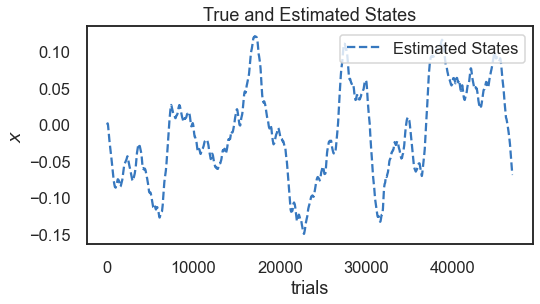

In [72]:
# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states[0]

# Smooth the data under the variational posterior
smoothed_obs = lds.smooth(state_means, data, input = inputs)

plt.figure(figsize=(8,4))
print(lds.emissions.Cs) 
plt_emissions = (np.squeeze(lds.emissions.Cs) * state_means[:]) #+ (lds.emissions.ds+5)
plt.plot(plt_emissions , '--', color=colors[0], label="Estimated States")

plt.ylabel("$x$")
plt.xlabel("trials")
plt.legend(loc='upper right')
plt.title("True and Estimated States")
plt.show()

sigma = [[[0.03987403]]] bias =  [[0.29591313]] input weight =  [[[ 0.5290923   0.6558256  -0.33084395]]]


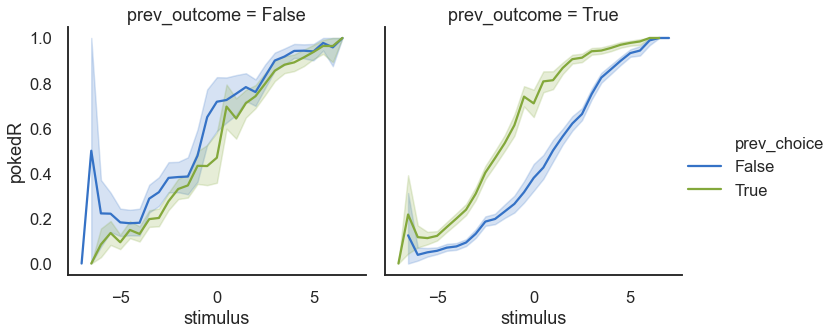

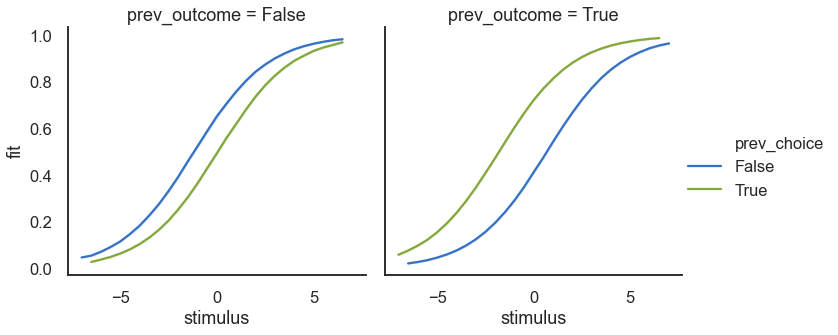

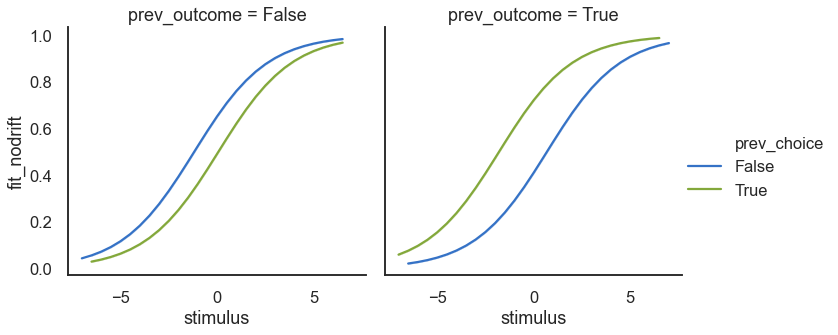

In [69]:
print("sigma =", lds.dynamics.Sigmas * np.sqrt(np.abs(lds.emissions.Cs)), "bias = ", lds.emissions.ds, 
      "input weight = ", lds.emissions.Fs)  

data = {}

data["pokedR"] = np.concatenate(np.array(emissions))
data["stimulus"] = inputs[:,0]
data["prev_choice"] = (inputs[:,1] == 1) | (inputs[:,2] == 1)
data["prev_outcome"] = (inputs[:,1] == 1) | (inputs[:,1] == -1)
data["rc"] = inputs[:,1] == 1
data["lc"] = inputs[:,1] == -1 
data["re"] = inputs[:,2] == 1
data["le"] = inputs[:,2] == -1

data["fit"] = np.concatenate(smoothed_obs)

lds.emissions.Cs = np.array([[[0.]]])
smoothed_obs_nod = lds.smooth(state_means, data, input = inputs)
data["fit_nodrift"] = np.concatenate(smoothed_obs_nod)
df = pd.DataFrame(data)

# plotting predictions with random drift
data["fit"] = np.concatenate(smoothed_obs)
df = pd.DataFrame(data)
sns.relplot(x="stimulus", y="pokedR",  hue = "prev_choice", col="prev_outcome", kind="line", data=df);
sns.relplot(x="stimulus", y="fit",  hue = "prev_choice", col="prev_outcome", kind="line", data=df);

# plotting predictions without random drift
sns.relplot(x="stimulus", y="fit_nodrift",  hue = "prev_choice", col="prev_outcome", kind="line", data=df);
